### Importing Libraries

In [401]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from IPython.display import clear_output
import plotly.graph_objects as go
from IPython.display import clear_output, display



### Loading Data

In [317]:

file_path = '/content/drive/My Drive/dataset.csv'
df = pd.read_csv(file_path)

df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [387]:
failure_features = ['Type', 'Air temperature [K]', 'Process temperature [K]',
                    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
failure_type_cols = ['TWF','HDF','PWF','OSF','RNF']

X = df[failure_features]
y_bin = df['Machine failure']

# Stage 2 target: only for failed machines
df_failure = df[df['Machine failure']==1].copy()
X_multi = df_failure[failure_features]
y_multi = df_failure[failure_type_cols].idxmax(axis=1)

In [386]:
corr = X.select_dtypes(include=np.number).corrwith(y_bin)
corr

,0
Air temperature [K],0.082556
Process temperature [K],0.035946
Rotational speed [rpm],-0.044188
Torque [Nm],0.191321
Tool wear [min],0.105448


In [266]:
print("Rows:", df.shape[0], "Columns:", df.shape[1])

Rows: 10000 Columns: 14


### EDA

#### INFO and Describe

In [267]:
print(df.info())

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

### Check for Missing Values

In [268]:
print(df.isnull().sum())

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


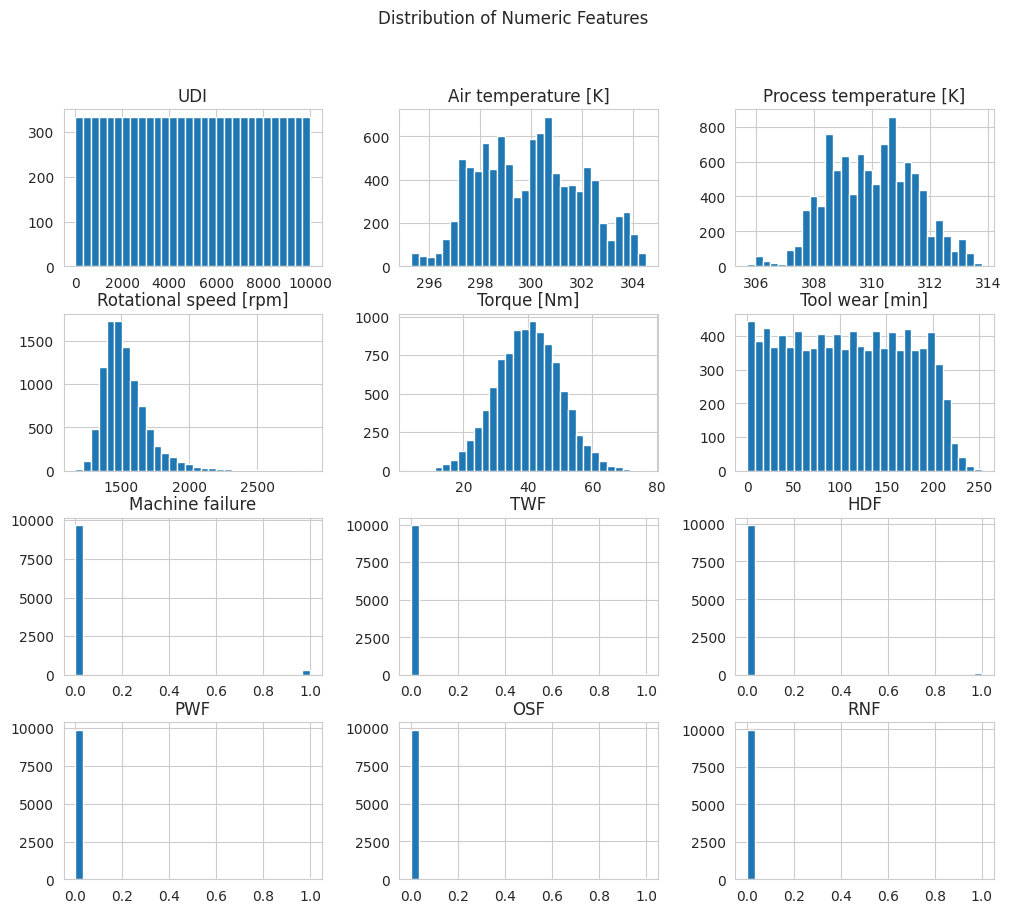

In [325]:
df.hist(figsize=(12, 10), bins=30)
plt.suptitle("Distribution of Numeric Features")
plt.show()


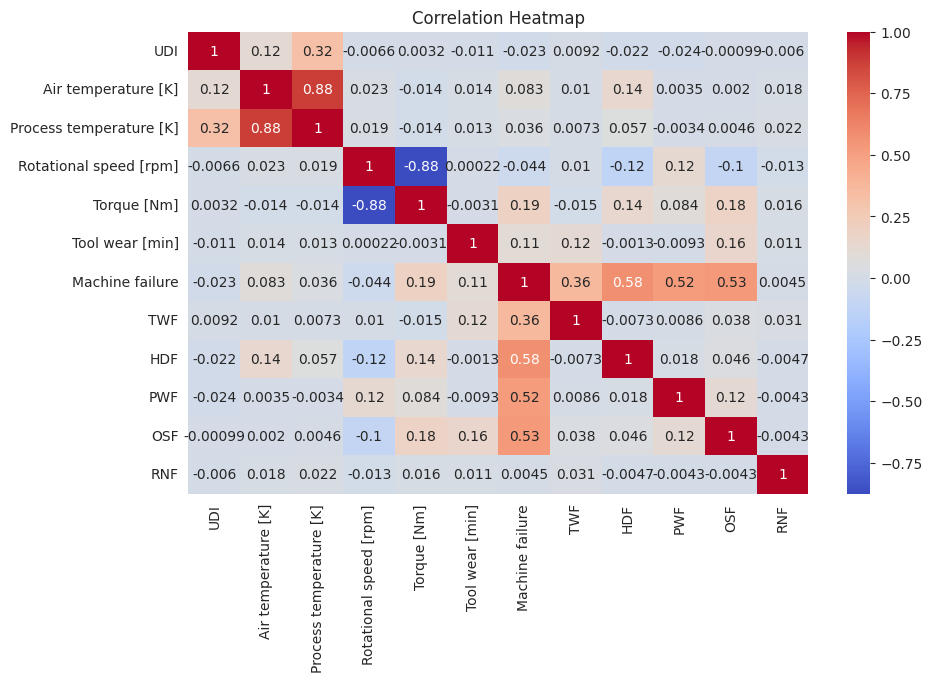

In [326]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


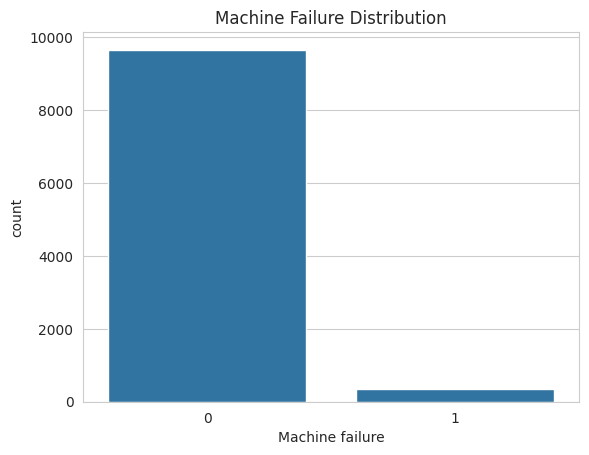

Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64


In [327]:
sns.countplot(x='Machine failure', data=df)
plt.title("Machine Failure Distribution")
plt.show()

print(df['Machine failure'].value_counts(normalize=True))


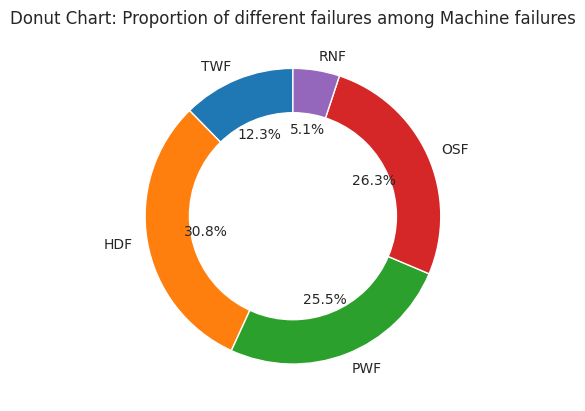

In [328]:
failure_counts = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum()
plt.pie(failure_counts, labels=failure_counts.index, autopct='%1.1f%%', startangle=90)
circle = plt.Circle((0, 0), 0.7, color='white')
plt.gca().add_artist(circle)
plt.title('Donut Chart: Proportion of different failures among Machine failures')
plt.show()

In [274]:
df.select_dtypes(include=['number']).groupby('Machine failure').mean()


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
Machine failure,,,,,,,,,,,
0,5012.878791,299.973999,309.995570,1540.260014,39.629655,106.693717,0.000000,0.000000,0.000000,0.000000,0.001863
1,4647.722714,300.886431,310.290265,1496.486726,50.168142,143.781711,0.135693,0.339233,0.280236,0.289086,0.002950


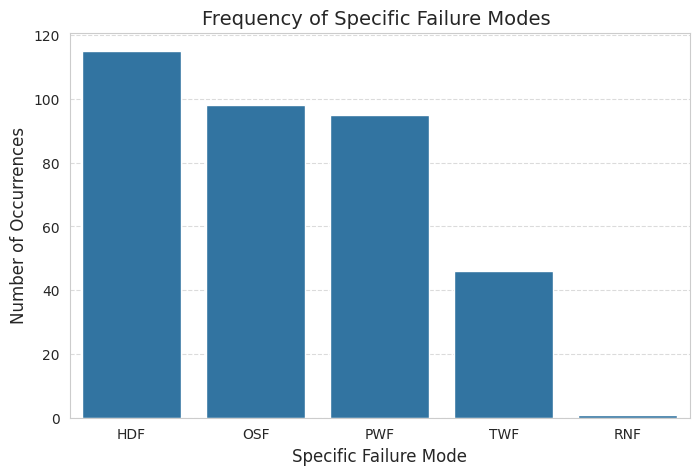

In [329]:
failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failed_df = df[df['Machine failure'] == 1]

failure_counts = failed_df[failure_modes].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=failure_counts.index, y=failure_counts.values)

plt.title('Frequency of Specific Failure Modes ', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Specific Failure Mode', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Duplicate Rows


In [330]:
# Handle duplicates
duplicate_rows_data = df[df.duplicated()]
print("Number of duplicate rows: ", duplicate_rows_data.shape[0])

Number of duplicate rows:  0


### Drop Unnecessory Columns

In [331]:
X = X.drop(["UDI", "Product ID"], axis=1)

### Handle Categorical Columns


In [333]:
failure_features = ['Type', 'Air temperature [K]', 'Process temperature [K]',
                    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
failure_type_cols = ['TWF','HDF','PWF','OSF','RNF']

categorical_features = ['Type']


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0


### Build A Pipeline

In [390]:
trf1 = ColumnTransformer([
    ('type', OneHotEncoder(handle_unknown='ignore'), [0])
], remainder='passthrough')

trf2 = ColumnTransformer([
    ('scale_num', StandardScaler(), list(range(1, 6)))
], remainder='passthrough')


In [388]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.2, stratify=y_bin, random_state=42
)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.2, stratify=y_multi, random_state=42
)

### Train And Evaluate The Model

In [391]:
binary_model = XGBClassifier(
    scale_pos_weight=(len(y_train_bin[y_train_bin==0]) / len(y_train_bin[y_train_bin==1])),
    learning_rate=0.05,
    n_estimators=400,
    max_depth=8,
    random_state=42
)
pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('model', binary_model)
])
pipe.fit(X_train_bin, y_train_bin)

y_pred = pipe.predict(X_test_bin)
print(" Model Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_test_bin, y_pred):.3f}")
print(f"Precision: {precision_score(y_test_bin, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test_bin, y_pred):.3f}")
print(f"F1-Score:  {f1_score(y_test_bin, y_pred):.3f}")
print("\nDetailed Report:")
print(classification_report(y_test_bin, y_pred))



 Model Evaluation Metrics:
Accuracy:  0.984
Precision: 0.773
Recall:    0.750
F1-Score:  0.761

Detailed Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.77      0.75      0.76        68

    accuracy                           0.98      2000
   macro avg       0.88      0.87      0.88      2000
weighted avg       0.98      0.98      0.98      2000



In [392]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = pipe.predict(X_test_bin)
y_true = y_test_bin
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[1917   15]
 [  17   51]]


In [395]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Stratified K-Fold to preserve class imbalance
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define multiple scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Perform cross-validation
results = cross_validate(pipe, X_train_bin, y_train_bin, cv=kfold, scoring=scoring, return_train_score=False)

# Print metrics for each fold
print("Cross-Validation Results (5-Folds):")
for i in range(len(results['test_accuracy'])):
    print(f"Fold {i+1}: "
          f"Acc={results['test_accuracy'][i]:.3f}, "
          f"Prec={results['test_precision'][i]:.3f}, "
          f"Rec={results['test_recall'][i]:.3f}, "
          f"F1={results['test_f1'][i]:.3f}")

# Print mean metrics
print("\nMean CV Scores:")
print(f"Accuracy:  {np.mean(results['test_accuracy']):.3f}")
print(f"Precision: {np.mean(results['test_precision']):.3f}")
print(f"Recall:    {np.mean(results['test_recall']):.3f}")
print(f"F1-Score:  {np.mean(results['test_f1']):.3f}")


pipe.fit(X_train_bin, y_train_bin)

# Predict on test set
y_pred = pipe.predict(X_test_bin)


Cross-Validation Results (5-Folds):
Fold 1: Acc=0.988, Prec=0.815, Rec=0.815, F1=0.815
Fold 2: Acc=0.982, Prec=0.755, Rec=0.685, F1=0.718
Fold 3: Acc=0.978, Prec=0.661, Rec=0.722, F1=0.690
Fold 4: Acc=0.979, Prec=0.698, Rec=0.685, F1=0.692
Fold 5: Acc=0.982, Prec=0.750, Rec=0.709, F1=0.729

Mean CV Scores:
Accuracy:  0.982
Precision: 0.736
Recall:    0.723
F1-Score:  0.729


####  Failure Type Model (Stage 2)


In [411]:
failure_type_cols = ['TWF','HDF','PWF','OSF','RNF']

y_train_multi = df_failure.loc[X_train_multi.index, failure_type_cols].idxmax(axis=1)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_multi)

y_test_multi = df_failure.loc[X_test_multi.index, failure_type_cols].idxmax(axis=1)
y_test_encoded = le.transform(y_test_multi)


pipe_multi = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('model', XGBClassifier(
        learning_rate=0.05,
        n_estimators=400,
        max_depth=6,
        random_state=42
    ))
])

pipe_multi.fit(X_train_multi, y_train_encoded)
def predict_failure_and_type(row):
    fail_prob = pipe_multi.predict_proba(row).max()
    will_fail = 1 if fail_prob > 0.7 else 0

    if will_fail:
        pred_class_num = pipe_multi.predict(row)[0]
        fail_type = le.inverse_transform([pred_class_num])[0]
        return "FAILURE", fail_type, fail_prob
    else:
        return "HEALTHY", None, fail_prob


row = X_test_multi.iloc[[21]]
fail_prob = pipe_multi.predict_proba(row).max()
will_fail = 1 if fail_prob > 0.7 else 0

if will_fail:
    pred_class_num = pipe_multi.predict(row)[0]
    fail_type = le.inverse_transform([pred_class_num])[0]
    status = "FAILURE"
else:
    fail_type = None
    status = "HEALTHY"

print(f"Status: {status}")
print(f"Failure Type: {fail_type}")
print(f"Probability: {fail_prob:.2f}")


Status: FAILURE
Failure Type: PWF
Probability: 0.89


In [414]:
log = []

for i in range(len(X_test_bin)):
    row = X_test_bin.iloc[i:i+1]
    true_label = y_test_bin.iloc[i]

    machine_id = row['Product ID'].values[0] if 'Product ID' in row.columns else f"Machine_{i}"
    machine_type = row['Type'].values[0] if 'Type' in row.columns else "Unknown"

    pred = pipe.predict(row)[0]
    prob = pipe.predict_proba(row)[0][1]  # probability of failure (class 1)

    # Log result
    log.append({
        'Index': i,
        'Machine_ID': machine_id,
        'Type': machine_type,
        'True_Label': true_label,
        'Predicted_Label': pred,
        'Failure_Probability': prob
    })

    if pred == 1:
        print(f"Maintenance Alert! Machine ID: {machine_id}, Type: {machine_type} "
              f"→ Predicted FAILURE (Prob={prob:.2f})")

    time.sleep(0.005)

log_df = pd.DataFrame(log)

print("\n--- Simulation Summary ---")
print(log_df.head(10))


Maintenance Alert! Machine ID: Machine_0, Type: L → Predicted FAILURE (Prob=1.00)
Maintenance Alert! Machine ID: Machine_21, Type: L → Predicted FAILURE (Prob=0.99)
Maintenance Alert! Machine ID: Machine_41, Type: M → Predicted FAILURE (Prob=1.00)
Maintenance Alert! Machine ID: Machine_43, Type: M → Predicted FAILURE (Prob=1.00)
Maintenance Alert! Machine ID: Machine_51, Type: L → Predicted FAILURE (Prob=0.95)
Maintenance Alert! Machine ID: Machine_64, Type: L → Predicted FAILURE (Prob=1.00)
Maintenance Alert! Machine ID: Machine_154, Type: L → Predicted FAILURE (Prob=1.00)
Maintenance Alert! Machine ID: Machine_159, Type: L → Predicted FAILURE (Prob=1.00)
Maintenance Alert! Machine ID: Machine_222, Type: L → Predicted FAILURE (Prob=0.94)
Maintenance Alert! Machine ID: Machine_246, Type: M → Predicted FAILURE (Prob=1.00)
Maintenance Alert! Machine ID: Machine_342, Type: M → Predicted FAILURE (Prob=0.50)
Maintenance Alert! Machine ID: Machine_377, Type: L → Predicted FAILURE (Prob=0.77)

### Visualization: Build a dashboard (Streamlit or notebook plots) to:
📈 Show incoming sensor data
⚙️ Track machine status (Healthy / At Risk)

In [412]:
def simple_dashboard(X_test, y_test, pipeline, n_rows=50, delay=0.3):
    air_temp_data = []
    torque_data = []
    status_data = []
    indexes = []

    print(" Starting Real-Time Machine Monitoring...\n")

    for i in range(min(n_rows, len(X_test))):
        row = X_test.iloc[i:i+1]

        prob = pipeline.predict_proba(row)[0][1]
        status = "At Risk" if prob > 0.7 else "Healthy"
        color = "red" if status == "At Risk" else "green"

        air_temp = row["Air temperature [K]"].values[0]
        torque = row["Torque [Nm]"].values[0]

        indexes.append(i)
        air_temp_data.append(air_temp)
        torque_data.append(torque)
        status_data.append(1 if status == "At Risk" else 0)

        clear_output(wait=True)
        plt.figure(figsize=(10,6))

        plt.subplot(2,1,1)
        plt.plot(indexes, air_temp_data, label="Air Temp [K]", color="blue", linewidth=2)
        plt.plot(indexes, torque_data, label="Torque [Nm]", color="orange", linewidth=2)
        plt.xlabel("Time (Row Index)")
        plt.ylabel("Sensor Values")
        plt.title("📈 Incoming Sensor Data")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2,1,2)
        plt.step(indexes, status_data, where='post', color='black', linewidth=2)
        plt.fill_between(indexes, 0, status_data, step='post', color=color, alpha=0.3)
        plt.ylim(-0.1, 1.1)
        plt.yticks([0,1], ["Healthy","At Risk"])
        plt.xlabel("Time (Row Index)")
        plt.title(f" Machine Status: {status} (Prob={prob:.2f})")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        if status == "At Risk":
            print(f" ALERT: Machine at RISK!  (Failure Probability = {prob:.2f})")

        time.sleep(delay)


/tmp/ipython-input-4195745515.py:55: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



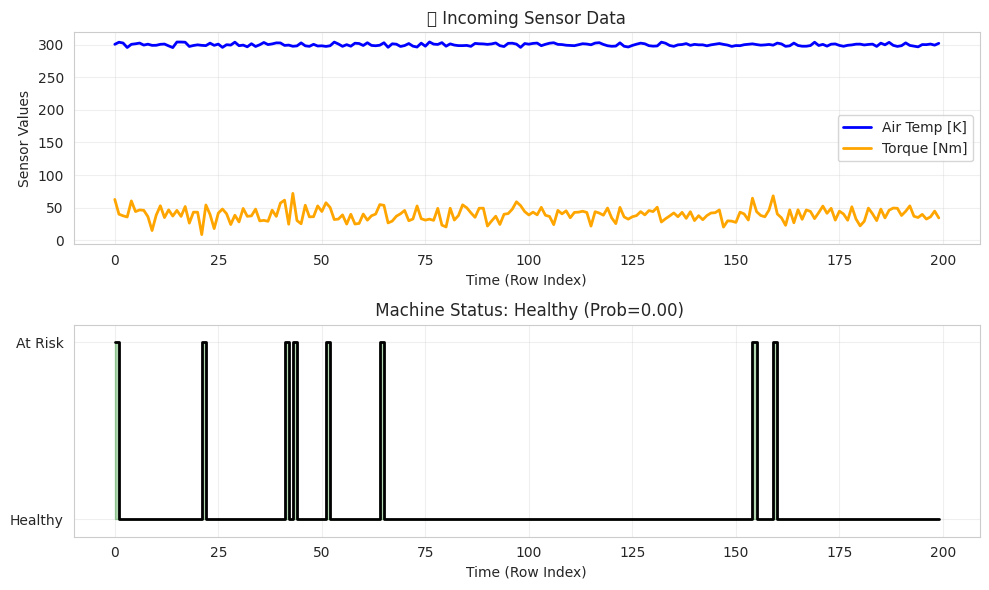

In [413]:
simple_dashboard(X_test_bin, y_test_bin, pipe, n_rows=200, delay=0)
